# Analysis-I: Basic Analysis done through python wrapper and compared with out C++ code.

This analysis is for comparing xpcs-eigen results to pyxpcs results. The input to analysis is specific to 8-id-i IMM file format. 

In [1]:
%load_ext autoreload
%autoreload

import numpy as np

from pyxpcs.reader import IMMReader8ID

from pyxpcs.structs import PyXPCSArray
from pyxpcs.config import PyXPCSDict
from pyxpcs.utils import config_from_8idhdf5, load_results
from pyxpcs.viz import plot_pix_sum, plot_as_image

import libpyxpcs as libpx

from pprint import pprint

## Input Data

Specify the input IMM file to use. The result file from the xpcs-eigen analysis that contains G2, IP, and IF. The HDF5 file that will be used to run the pyxpcs analysis.

In [2]:
IMM_FILE = "/home/faisal/Development/xpcs-eigen/data/pyxpcs/A002_MJ_PMA_47g61kDa_att2_160C_Lq0_001_00001-00512.imm"
HDF5_FILE = "/home/faisal/Development/xpcs-eigen/data/pyxpcs/A002_MJ_PMA_47g61kDa_att2_160C_Lq0_001_0002-0512.hdf"
RESULT_FILE = "/home/faisal/Development/xpcs-eigen/data/pyxpcs/A002_MJ_PMA_47g61kDa_att2_160C_Lq0_001_0002-0512.original.hdf"


## Configuration

Load the configuration that are specific to 8-ID-I


In [3]:
config = config_from_8idhdf5(HDF5_FILE)
pprint(config)

PyXPCSDict({'rows': 1556, 'cols': 516, 'pixels': 802896, 'frame_start': 2, 'frame_end': 512, 'frame_start_limit': 2, 'frame_end_limit': 512, 'frames': 510, 'delays_per_level': 4, 'dqmap': array([[54, 54, 54, ..., 54, 54, 54],
       [54, 54, 54, ..., 54, 54, 54],
       [54, 54, 54, ..., 54, 54, 54],
       ...,
       [54, 54, 54, ..., 54, 54, 54],
       [54, 54, 54, ..., 54, 54, 54],
       [54, 54, 54, ..., 54, 54, 54]], dtype=int32), 'sqmap': array([[269, 269, 269, ..., 270, 270, 270],
       [269, 269, 268, ..., 270, 270, 270],
       [269, 269, 268, ..., 270, 270, 270],
       ...,
       [269, 268, 268, ..., 269, 270, 270],
       [269, 268, 268, ..., 269, 270, 270],
       [269, 269, 268, ..., 270, 270, 270]], dtype=int32), 'roi_1d': array([   0,    2,    4, ..., 3106, 3108, 3110]), 'beam_center_x': 691.8410299003323, 'beam_center_y': 159.73978405315614, 'detector_distance': 3930.0, 'x_energy': 10.965, 'pixel_size': 0.055})


## Load data


In [4]:
frames_to_do = 25 #config['frames'] # If you want to limit the analyis to certain #of frames.

reader = IMMReader8ID(IMM_FILE,  # Input file
                      no_of_frames=frames_to_do,  # Total number of frames to work with.
                      skip_frames=config['frame_start_limit'] # Frames to skip, typically specified in HDF5 file.
                     )

# Get the data read from the reader
data = reader.array()

# Finalize prepare ready to be fed into anlaysis functions.
data.finalize()

# The data currently returned is in list of list format
valid_pixels, rows, values = data.get_lil()

# valid_pixels = [1, 5, 10, 30]
# rows = [[0, 10, 30, 50...], [0, 20, 0], ...]
# values = [[1, 1, 1, 1], [1, 1, 1, 1]]

26


In [5]:
# Save data file
import pickle
pickle.dump(valid_pixels, open("valid_pixels.p", "wb"))
pickle.dump(rows, open("rows.p", "wb"))
pickle.dump(values, open("values.p", "wb"))

## Plotting

Basic plotting to verify the data is read properly.

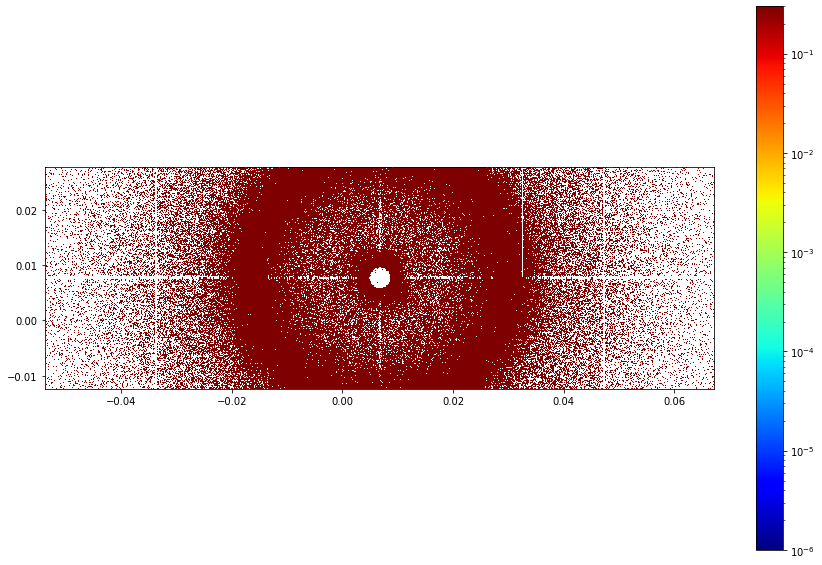

In [6]:
pixel_sum = data.pixel_sum()
pixsum = pixel_sum.reshape((config['cols'], config['rows']))
plot_pix_sum(pixsum, config)

## Analysis


In [7]:
config = {
    'frames': frames_to_do,
    'pixels': config['cols'] * config['rows'],
    'delays_per_level': config['delays_per_level'],
    'rows': config['rows'],
    'cols': config['cols'],  
}

result = libpx.multitau(valid_pixels, rows, values, config)
result.shape

(3, 13, 802896)

In [8]:
G2 = result[0, 0, :].reshape(config['cols'], config['rows'])
IP = result[1, 0, :].reshape(config['cols'], config['rows'])
IF = result[2, 0, :].reshape(config['cols'], config['rows'])

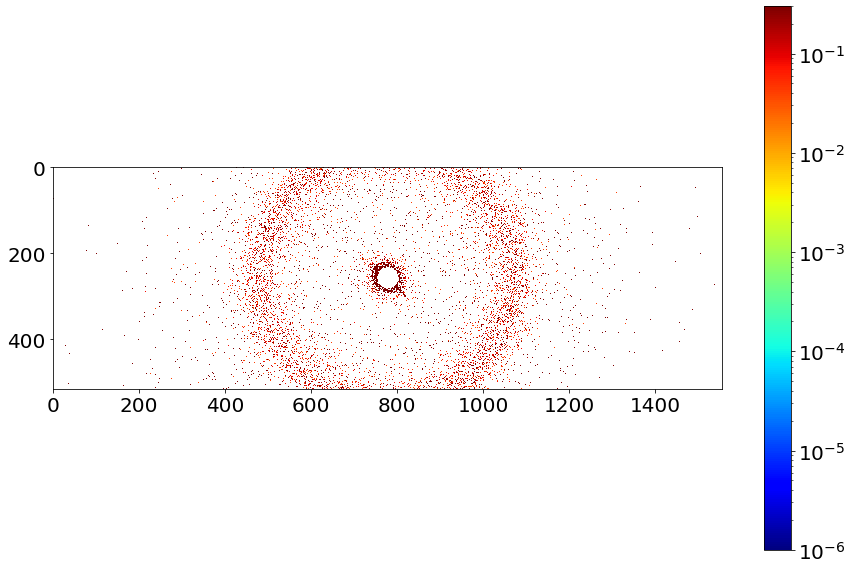

In [9]:
plot_as_image(G2)

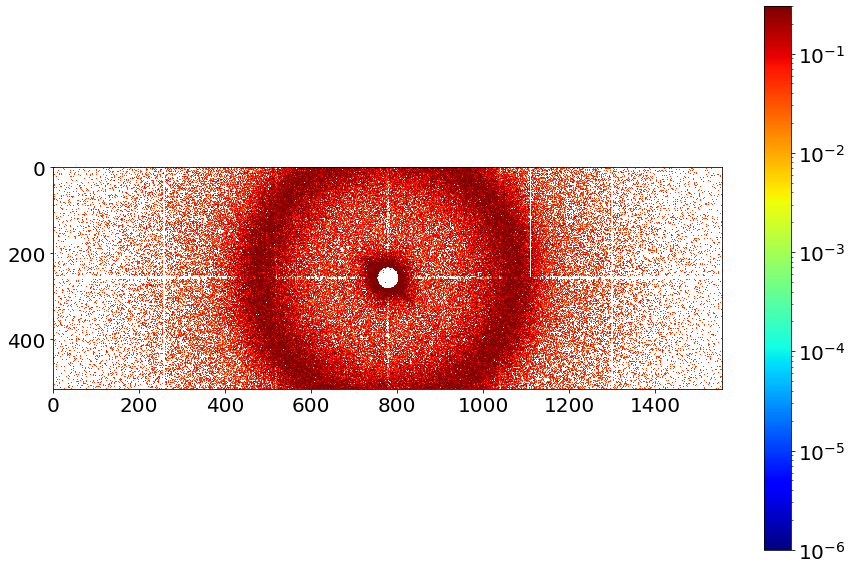

In [10]:
plot_as_image(IP)

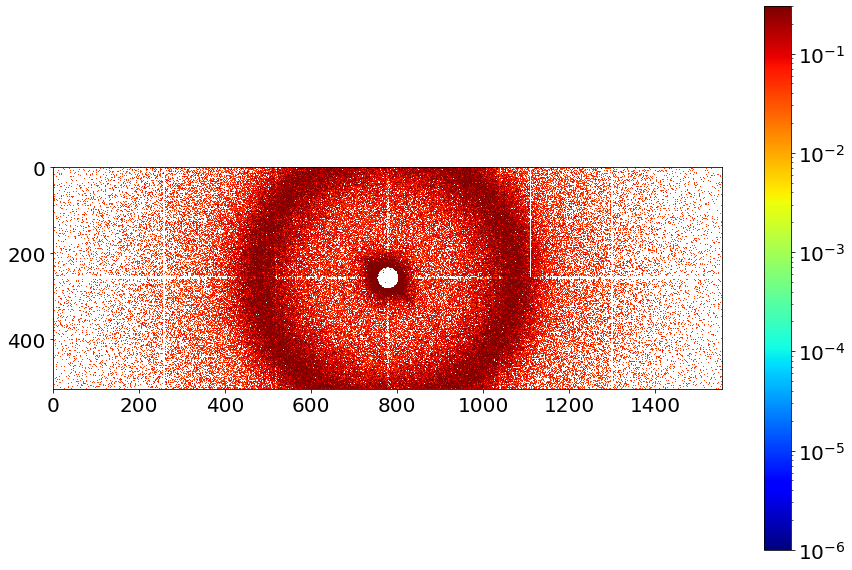

In [11]:
plot_as_image(IF)

## Verification

Verify the results with the C++ version directly

In [12]:
config2 = config_from_8idhdf5(RESULT_FILE)

In [13]:
ret = load_results(RESULT_FILE, '/exchange', ['pixelSum', 'G2', 'IP', 'IF'])

pixel_sum = ret['pixelSum']
G2 = ret['G2']
IP = ret['IP']
IF = ret['IF']

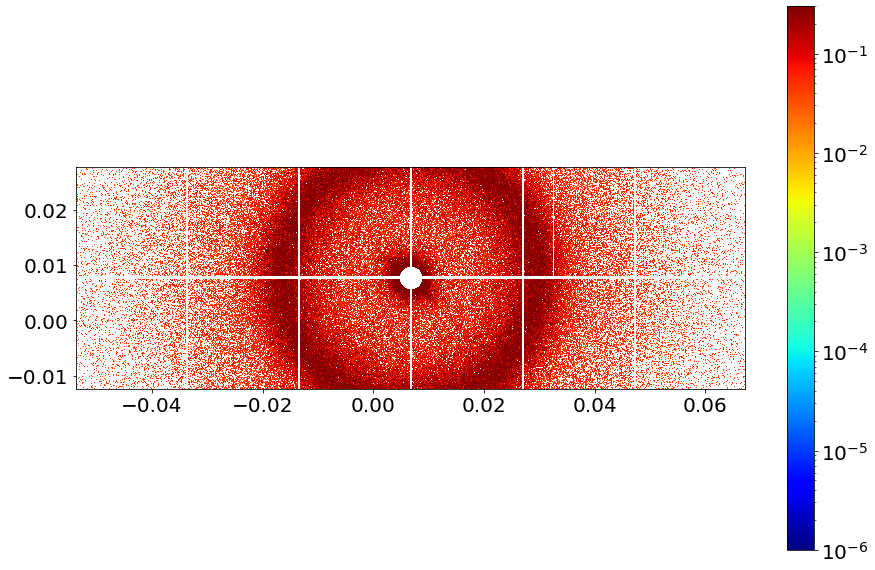

In [14]:
plot_pix_sum(pixel_sum, config2)

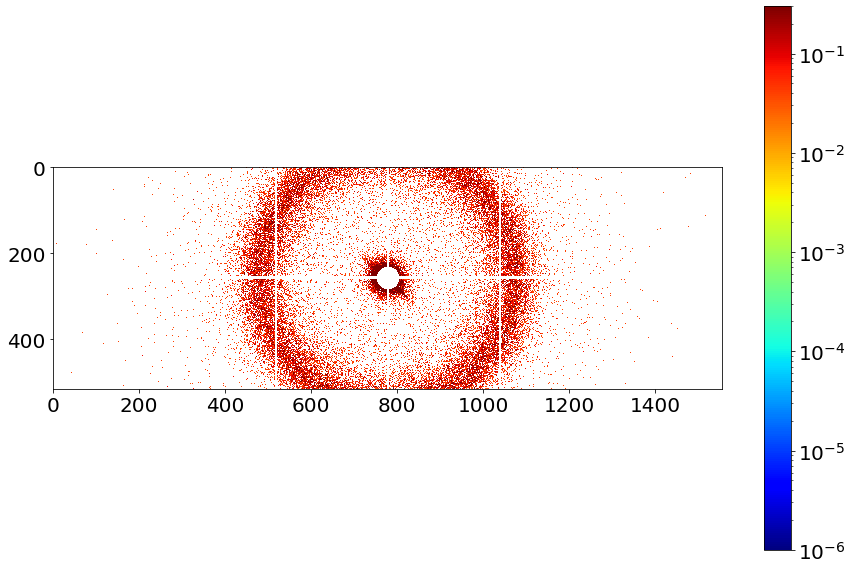

In [15]:
plot_as_image(G2[0].reshape(config2['cols'], config2['rows']))

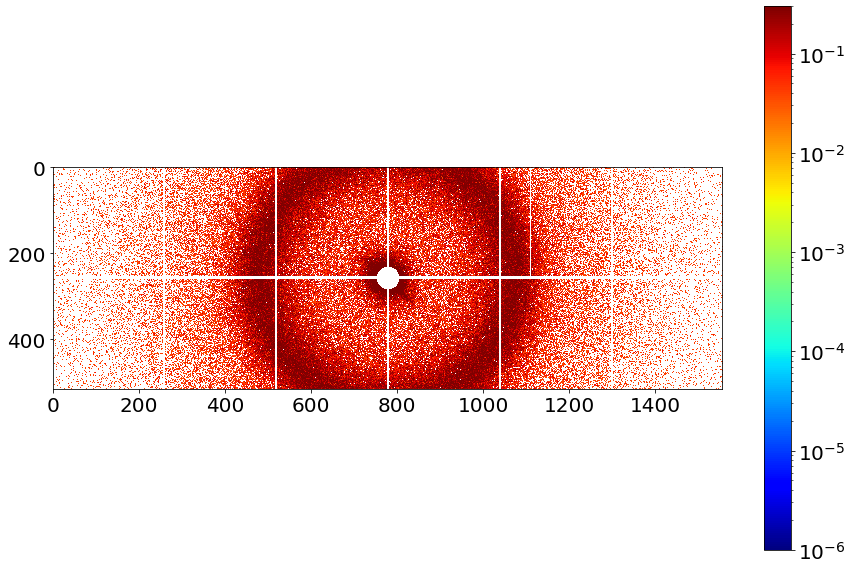

In [16]:
plot_as_image(IP[0].reshape(config2['cols'], config2['rows']))